# COVID-19 Data Analysis
**Joe Corliss**

[Data source](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

## Execution Options

In [1]:
# Config
DATA_PATH = '../data/'
random_state = 0

# Modeling
metric = 'confirmed'  # Variable of interest
metric_min = {'confirmed': round(2**9), 'deaths': round(2**3)}  # Filter out samples where the metric is below this value
log_metric = True  # Take log of the metric?
days_history = 14  # Number of consecutive past days to use for prediction (including the current day)
days_horizon = 7  # Number of days ahead to predict

In [2]:
# Validate input
assert isinstance(DATA_PATH, str), "Bad input for option 'DATA_PATH'"
assert isinstance(random_state, int), "Bad input for option 'random_state'"
assert metric in {'confirmed', 'deaths'}, "Bad input for option 'metric'"
assert isinstance(metric_min, dict), "Bad input for option 'metric_min'"
assert isinstance(log_metric, bool), "Bad input for option 'log_metric'"
assert isinstance(days_history, int) and days_history >= 1, "Bad input for option 'days_history'"
assert isinstance(days_horizon, int) and days_horizon >= 1, "Bad input for option 'days_horizon'"

## Imports

In [3]:
import sys

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

In [5]:
# Check package versions
assert sys.version[:3] == '3.6', 'Unexpected Python version: expected 3.6, got {}'.format(sys.version[:3])
assert mpl.__version__.rpartition('.')[0] == '3.1', 'Unexpected matplotlib version: expected 3.1, got {}'.format(mpl.__version__.rpartition('.')[0])
assert np.__version__.rpartition('.')[0] == '1.18', 'Unexpected numpy version: expected 1.18, got {}'.format(np.__version__.rpartition('.')[0])
assert pd.__version__.rpartition('.')[0] == '1.0', 'Unexpected pandas version: expected 1.0, got {}'.format(pd.__version__.rpartition('.')[0])
assert sklearn.__version__.rpartition('.')[0] == '0.22', 'Unexpected scikit-learn version: expected 0.22, got {}'.format(sklearn.__version__.rpartition('.')[0])

In [6]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

In [7]:
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

## Load data

In [8]:
values = pd.read_csv(DATA_PATH + 'time_series_covid19_{metric}_global.txt'.format(metric=metric))

In [9]:
print('Data updated to:', values.columns[-1])

Data updated to: 4/4/20


In [10]:
values.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 78 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  81 non-null     object 
 1   Country/Region  259 non-null    object 
 2   Lat             259 non-null    float64
 3   Long            259 non-null    float64
 4   1/22/20         259 non-null    int64  
 5   1/23/20         259 non-null    int64  
 6   1/24/20         259 non-null    int64  
 7   1/25/20         259 non-null    int64  
 8   1/26/20         259 non-null    int64  
 9   1/27/20         259 non-null    int64  
 10  1/28/20         259 non-null    int64  
 11  1/29/20         259 non-null    int64  
 12  1/30/20         259 non-null    int64  
 13  1/31/20         259 non-null    int64  
 14  2/1/20          259 non-null    int64  
 15  2/2/20          259 non-null    int64  
 16  2/3/20          259 non-null    int64  
 17  2/4/20          259 non-null    int

Check that there is no unexpected missing data:

In [11]:
assert values.notnull().all()[1:].all(), 'Unexpected missing data!'

In [12]:
values.drop(columns={'Lat', 'Long'}, inplace=True)

In [13]:
values.rename(columns={'Country/Region': 'country', 'Province/State': 'province'}, inplace=True)

In [14]:
values.sample(5)

,province,country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20
79,Xinjiang,China,0,2,2,3,4,5,10,13,14,17,18,21,24,29,32,36,39,42,45,49,55,59,63,65,70,71,75,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76
108,French Polynesia,France,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,3,6,11,15,18,18,25,25,30,30,30,30,36,36,37,37,39,40
7,NaN,Armenia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,4,8,18,26,52,78,84,115,136,160,194,235,249,265,290,329,407,424,482,532,571,663,736,770
30,NaN,Bulgaria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,7,7,23,41,51,52,67,92,94,127,163,187,201,218,242,264,293,331,346,359,399,422,457,485,503
118,NaN,Gambia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,3,3,3,3,3,4,4,4,4,4,4,4


## Look at Countries Split Up by Province/State

Number of distinct provinces for countries with more than one province:

In [15]:
country_counts = values['country'].value_counts()
print(country_counts[country_counts > 1])

China             33
Canada            15
United Kingdom    11
France            10
Australia          8
Netherlands        5
Denmark            3
Name: country, dtype: int64


List current value by country and province, sorted by country ascending, then value descending:

In [16]:
values.loc[values['country'].map(country_counts > 1)].iloc[:, [1, 0, -1]].sort_values(
    ['country', values.columns[-1]], ascending=[True, False]
)

,country,province,4/4/20
9,Australia,New South Wales,2493
14,Australia,Victoria,1115
11,Australia,Queensland,900
15,Australia,Western Australia,436
12,Australia,South Australia,407
8,Australia,Australian Capital Territory,93
13,Australia,Tasmania,80
10,Australia,Northern Territory,26
44,Canada,Quebec,6101
42,Canada,Ontario,3630


## Data Processing

Add a new variable `locale` that combines the country and provice (if applicable):

In [17]:
values.insert(0, 'locale', values['country'].where(
    values['province'].isnull(),
    values['country'] + '/' + values['province']
))

Replaces the `country` and `province` columns:

In [18]:
values.drop(columns={'province', 'country'}, inplace=True)

In [19]:
values.sample(5)

,locale,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20
95,Djibouti,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,3,3,11,11,12,14,18,18,30,33,40,49,50
221,United Kingdom/Isle of Man,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,5,13,23,23,25,29,32,42,49,60,68,95,114,126
240,Libya,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,8,8,10,10,11,11,18
25,Bhutan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,4,4,4,4,5,5,5
222,United Kingdom/Montserrat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,5,5,5,5,5,5,5,5,6,6


Plot values for each locale (repeat the second cell below):

In [20]:
idx = 0

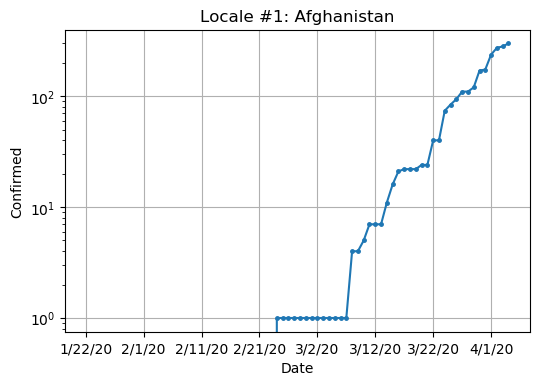

In [21]:
if idx < values.shape[0]:
    while values.iloc[idx, -1] < 100:
        idx += 1
    plt.figure(dpi=100)
    values.iloc[idx, 1:].plot.line(marker='.', markersize=5, logy=log_metric)
    plt.title('Locale #{idx}: {locale}'.format(idx=idx + 1, locale=values.iloc[idx, 0]))
    plt.xlabel('Date')
    plt.ylabel(metric.capitalize())
    plt.grid(True)
    idx += 1

Stack the data:

In [22]:
values_melt = values.melt(id_vars=['locale'], var_name='date', value_name='value')

In [23]:
values_melt['date'] = pd.to_datetime(values_melt['date'])

In [24]:
values_melt.sample(5)

,locale,date,value
18300,New Zealand,2020-04-01,708
10847,Vietnam,2020-03-03,16
14728,Uruguay,2020-03-18,50
15433,Madagascar,2020-03-21,3
8831,Bhutan,2020-02-25,0


Filter by the minimum required metric value:

In [25]:
values_melt = values_melt.loc[values_melt['value'] >= metric_min[metric]]

Apply log to the metric values, if specified:

In [26]:
if log_metric:
    values_melt['value'] = values_melt['value'].map(np.log10)

In [27]:
values_melt.sample(5)

,locale,date,value
14577,China/Shandong,2020-03-18,2.881385
11721,China/Jiangxi,2020-03-07,2.970812
9387,China/Hunan,2020-02-27,3.007321
6276,China/Henan,2020-02-15,3.083503
17155,China/Hong Kong,2020-03-28,2.748963


## Construct Final Datasets

In [28]:
final_schema = pd.DataFrame(columns=['locale', 'date']
                                    + ['value_d{}'.format(idx) for idx in range(-days_history + 1, 1)]
                                    + ['value_d+{}'.format(days_horizon)])

In [29]:
final_schema

,locale,date,value_d-13,value_d-12,value_d-11,value_d-10,value_d-9,value_d-8,value_d-7,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7


In [30]:
train_to_append_list = []
pred_to_append_list = []

In [31]:
for locale in sorted(values_melt['locale'].unique()):
    values_melt_locale = values_melt.loc[values_melt['locale'] == locale].sort_values('date')
    
    # Add to training data
    for idx in range(values_melt_locale.shape[0] - days_history - days_horizon + 1):
        train_to_append = values_melt_locale.iloc[idx + (days_history - 1), :2].to_dict()
        train_to_append.update(zip(final_schema.columns[2:-1], values_melt_locale['value'].iloc[idx : idx + days_history]))
        train_to_append[final_schema.columns[-1]] = values_melt_locale['value'].iloc[idx + (days_history - 1) + days_horizon]
        train_to_append_list.append(train_to_append)
        
    # Add to prediction data
    if days_history <= values_melt_locale.shape[0]:  # Can only predict if we have enough days of history
        pred_to_append = values_melt_locale.iloc[-1, :2].to_dict()
        pred_to_append.update(zip(final_schema.columns[2:-1], values_melt_locale['value'].iloc[-days_history:]))
        pred_to_append_list.append(pred_to_append)

In [32]:
train = final_schema.append(train_to_append_list, ignore_index=True)
pred = final_schema.append(pred_to_append_list, ignore_index=True)

In [33]:
train = train.sample(frac=1, random_state=random_state)
train = train.sort_values('date')

In [34]:
train.set_index(['locale', 'date'], inplace=True, verify_integrity=True)
pred.set_index(['locale', 'date'], inplace=True, verify_integrity=True)

In [35]:
train.head()

value_d-13  value_d-12  value_d-11  value_d-10  \
locale      date                                                         
China/Hubei 2020-02-06    2.739572    2.881385    3.024486    3.153205   
            2020-02-07    2.881385    3.024486    3.153205    3.550717   
            2020-02-08    3.024486    3.153205    3.550717    3.550717   
            2020-02-09    3.153205    3.550717    3.550717    3.690462   
            2020-02-10    3.550717    3.550717    3.690462    3.763877   

                        value_d-9  value_d-8  value_d-7  value_d-6  value_d-5  \
locale      date                                                                
China/Hubei 2020-02-06   3.550717   3.550717   3.690462   3.763877   3.854488   
            2020-02-07   3.550717   3.690462   3.763877   3.854488   4.048325   
            2020-02-08   3.690462   3.763877   3.854488   4.048325   4.131041   
            2020-02-09   3.763877   3.854488   4.048325   4.131041   4.222144   
            2020-02-10   3.854488   4.048325   4.131041   4.222144   4.293694   

                        value_d-4  value_d-3  value_d-2  value_d-1  value_d0  \
locale      date                                                               
China/Hubei 2020-02-06   4.048325   4.131041   4.222144   4.293694  4.344628   
            2020-02-07   4.131041   4.222144   4.293694   4.344628  4.397123   
            2020-02-08   4.222144   4.293694   4.344628   4.397123  4.432969   
            2020-02-09   4.293694   4.344628   4.397123   4.432969  4.471746   
            2020-02-10   4.344628   4.397123   4.432969   4.471746  4.501443   

                        value_d+7  
locale      date                   
China/Hubei 2020-02-06   4.683101  
            2020-02-07   4.735647  
            2020-02-08   4.750115  
            2020-02-09   4.764789  
            2020-02-10   4.778072

In [36]:
pred.head()

,,value_d-13,value_d-12,value_d-11,value_d-10,value_d-9,value_d-8,value_d-7,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7
locale,date,,,,,,,,,,,,,,,
Australia/New South Wales,2020-04-04,2.825426,2.825426,2.912753,3.012415,3.086004,3.147676,3.208710,3.253096,3.307924,3.307924,3.338855,3.361350,3.378216,3.396722,NaN
Austria,2020-04-04,3.554126,3.650696,3.722881,3.747256,3.839415,3.884059,3.917558,3.943890,3.983085,4.007748,4.029830,4.046456,4.061603,4.071182,NaN
Belgium,2020-04-04,3.531607,3.573220,3.630326,3.693463,3.794836,3.862370,3.960661,4.034869,4.075510,4.106361,4.145010,4.186052,4.224533,4.265549,NaN
Brazil,2020-04-04,3.189209,3.284205,3.351603,3.407221,3.474944,3.533645,3.591510,3.629002,3.660771,3.757168,3.834802,3.905472,3.956936,4.015360,NaN
Chile,2020-04-04,2.800717,2.872739,2.964731,3.057666,3.115943,3.206826,3.280806,3.330211,3.388989,3.437433,3.481586,3.531990,3.572523,3.619198,NaN


Check the size of the dataset:

In [37]:
print('The training data has {} samples'.format(train.shape[0]))
print('Predictions will be made for {} locales'.format(pred.shape[0]))

The training data has 583 samples
Predictions will be made for 47 locales


## Model Training and Validation

In [38]:
# model = linear_model.LassoCV(
#     eps=1e-8,
#     fit_intercept=True,
#     max_iter=100000,
#     n_jobs=-1,
#     random_state=random_state,
# )

In [39]:
model = linear_model.ElasticNetCV(
    l1_ratio=[pow(x, 1/3) for x in np.linspace(0.001, 1, 10)],
    eps=1e-8,
    n_alphas=100,
    fit_intercept=True,
    max_iter=100000,
    cv=TimeSeriesSplit(),
    n_jobs=-1,
    random_state=random_state,
    selection='random',
)

In [40]:
model.fit(train.iloc[:, :-1], train.iloc[:, -1])

ElasticNetCV(alphas=None, copy_X=True,
             cv=TimeSeriesSplit(max_train_size=None, n_splits=5), eps=1e-08,
             fit_intercept=True,
             l1_ratio=[0.10000000000000002, 0.48202845283504603,
                       0.6064126994506963, 0.6938232073815802,
                       0.763460672149231, 0.822289851862149, 0.8737260372210359,
                       0.9197289686814338, 0.961539774357182, 1.0],
             max_iter=100000, n_alphas=100, n_jobs=-1, normalize=False,
             positive=False, precompute='auto', random_state=0,
             selection='random', tol=0.0001, verbose=0)

In [41]:
model.coef_

array([ 0.03501593,  0.02502039, -0.        , -0.04587415, -0.12481518,
        0.08855439, -0.18010521, -0.11003999, -0.01298119, -0.41617016,
       -0.14239197, -0.21514239, -0.13019283,  2.22668102])

In [42]:
model.intercept_

0.010060174675747824

In [43]:
if isinstance(model, sklearn.linear_model._coordinate_descent.ElasticNetCV):
    print(model.l1_ratio_)

1.0


In [44]:
model.alpha_

6.376546671112636e-06

In [45]:
# min(model.alphas_), max(model.alphas_)

Cross-validated mean absolute error:

In [46]:
mean_abs_errors = -cross_val_score(
    estimator=linear_model.ElasticNet(
        alpha=model.alpha_,
        l1_ratio=model.l1_ratio_,
        max_iter=100000,
        random_state=random_state,
        selection='random',
    ),
    X=train.iloc[:, :-1],
    y=train.iloc[:, -1],
    scoring='neg_mean_absolute_error',
    cv=TimeSeriesSplit(),
    n_jobs=-1,
)

In [47]:
sorted(mean_abs_errors)

[0.012987020779766994,
 0.026352461880022264,
 0.027079802456694932,
 0.027365782918138834,
 0.033760962701806445]

## Model Selection Information

In [48]:
pd.DataFrame(
    data={
        'days_history': days_history,
        'days_selected': (model.coef_ != 0).sum(),
        'metric_min': metric_min[metric],
        'n_samples': train.shape[0],
        'samples_per_param': train.shape[0]/(days_history + 1),
        'mean_error': mean_abs_errors.mean(),
    },
    index=[0],
)

,days_history,days_selected,metric_min,n_samples,samples_per_param,mean_error
0,14,13,512,583,38.866667,0.025509


## Predictions

In [49]:
pred['value_d+{}'.format(days_horizon)] = model.predict(pred.iloc[:, :-1])

In [50]:
if log_metric:
    for col in pred.columns:
        pred[col] = pred[col].map(lambda x: round(10**x))

In [51]:
pred

,,value_d-13,value_d-12,value_d-11,value_d-10,value_d-9,value_d-8,value_d-7,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7
locale,date,,,,,,,,,,,,,,,
Australia/New South Wales,2020-04-04,669,669,818,1029,1219,1405,1617,1791,2032,2032,2182,2298,2389,2493,3196
Austria,2020-04-04,3582,4474,5283,5588,6909,7657,8271,8788,9618,10180,10711,11129,11524,11781,14176
Belgium,2020-04-04,3401,3743,4269,4937,6235,7284,9134,10836,11899,12775,13964,15348,16770,18431,28846
Brazil,2020-04-04,1546,1924,2247,2554,2985,3417,3904,4256,4579,5717,6836,8044,9056,10360,20368
Chile,2020-04-04,632,746,922,1142,1306,1610,1909,2139,2449,2738,3031,3404,3737,4161,6934
China/Anhui,2020-04-04,990,990,990,990,990,990,990,990,990,990,990,990,990,990,996
China/Beijing,2020-04-04,522,537,558,561,566,569,573,577,577,580,580,582,584,585,595
China/Chongqing,2020-04-04,577,578,578,578,578,578,578,579,579,579,579,579,579,579,584
China/Guangdong,2020-04-04,1413,1415,1428,1433,1448,1456,1467,1475,1484,1494,1501,1507,1514,1516,1553
